In [1]:
!pip install -q transformers

In [2]:
!pip install -q datasets jiwer

In [3]:
import pandas as pd
import os

# Path to the folders
images_folder = '/kaggle/input/khatt-arabic-hand-written-lines/images'
labels_folder = '/kaggle/input/khatt-arabic-hand-written-lines/labels'

# List to store image paths and labels
data = []

# Iterate over files in images folder
for image_file in os.listdir(images_folder):
    if image_file.endswith(('.png', '.jpg', '.jpeg')):
        # Get image path
        image_path = os.path.join(images_folder, image_file)
        
        # Get corresponding label
        label_file = os.path.splitext(image_file)[0] + '.txt'
        label_path = os.path.join(labels_folder, label_file)
        if os.path.exists(label_path):
            with open(label_path, 'r', encoding='windows-1256') as f:
                label = f.read().strip()
        else:
            label = None
        
        # Add image path and label to data list
        data.append({'image_path': image_path, 'label': label})

# Create DataFrame from the data list
df = pd.DataFrame(data)
df.head()

,image_path,label
0,/kaggle/input/khatt-arabic-hand-written-lines/...,طبية من مؤلفات أبو بكر الرازي
1,/kaggle/input/khatt-arabic-hand-written-lines/...,يظل ناقصًا تماما، وغير قادر على تحقيق الكمال ا...
2,/kaggle/input/khatt-arabic-hand-written-lines/...,ذهب نوح مظفر ضرغام بصحبة رؤوف بن لؤي رايق ظافر...
3,/kaggle/input/khatt-arabic-hand-written-lines/...,شيخ . كان جاري في الخيمة يتكلم وهو نائم بكلما...
4,/kaggle/input/khatt-arabic-hand-written-lines/...,هل تعلم فائدة الكلمات التالية لهذا النص: مشمش،


In [4]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.1)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [5]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class Dataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=47):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['image_path'][idx]
        text = self.df['label'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [6]:
from transformers import TrOCRProcessor
from transformers import AutoTokenizer
from transformers import VisionEncoderDecoderModel

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

tokenizer2 = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")
processor.tokenizer = tokenizer2

#model defining
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-stage1")
train_dataset = Dataset(root_dir='',
                           df=train_df,
                           processor=processor)
eval_dataset = Dataset(root_dir='',
                           df=test_df,
                           processor=processor)

2024-05-18 07:36:11.269098: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 07:36:11.269202: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 07:36:11.391865: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/720k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [7]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 10237
Number of validation examples: 1138


In [8]:
# max_label_size = 0
# # Iterate over all indices in eval_dataset
# for idx in range(len(train_dataset)):
#     encoding = train_dataset[idx]
#     for k, v in encoding.items():
#         if k == 'labels' and v.shape[0] > max_label_size:
#             max_label_size = v.shape[0]
#             max_label_idx = idx

# for idx in range(len(eval_dataset)):
#     encoding = eval_dataset[idx]
#     for k, v in encoding.items():
#         if k == 'labels' and v.shape[0] > max_label_size:
#             max_label_size = v.shape[0]
#             max_label_idx = idx

# if max_label_idx is not None:
#     print(f"Maximum label size found at index {max_label_idx}, with size {max_label_size}.")
# else:
#     print("No 'labels' key found in eval_dataset.")


In [9]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([47])


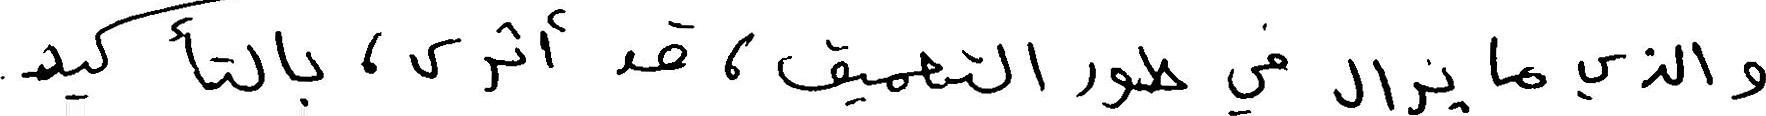

In [10]:
image = Image.open(train_dataset.root_dir + train_df['image_path'][0]).convert("RGB")
image

In [11]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.tokenizer.decode(labels, skip_special_tokens=True)
print(label_str)
print(labels)

والذي ما يزال في طور التعميق ، قد أثرى ، بالتأكيد.
tensor([   33,  6689,  2563,   331,  3262,   289,  6144,  1152, 32957,   198,
          130,   416, 18083,   130,  4350,   210,   225,  2058,    48,    34,
           31,    31,    31,    31,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31])


In [12]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=16)

In [13]:
# from transformers import VisionEncoderDecoderModel
# import torch

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")
# model.to(device)
# model.summary

In [14]:
import torch.nn as nn
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

#model.config.vocab_size = model.config.decoder.vocab_size

model.decoder.config.vocab_size = processor.tokenizer.vocab_size
model.config.vocab_size = model.config.decoder.vocab_size
model.decoder.output_projection = nn.Linear(256, processor.tokenizer.vocab_size)
model.decoder.model.decoder.embed_tokens = nn.Embedding(processor.tokenizer.vocab_size, 256, padding_idx=1)


# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 47
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 8

In [15]:
from datasets import load_metric

cer_metric = load_metric("cer")
wer_metric = load_metric("wer")

/tmp/ipykernel_34/782987868.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")
/opt/conda/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for cer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/cer/cer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for wer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/wer/wer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [16]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

def compute_wer(pred_ids, label_ids):
    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return wer

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

In [22]:
from transformers import AdamW
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import LambdaLR

train_loss_list = []
CER_list = []
WER_list = []
optimizer = AdamW(model.parameters(), lr=5e-5,no_deprecation_warning=True)
print("Learning rate =", optimizer.param_groups[0]['lr'])


for epoch in range(10):  # loop over the dataset multiple times
    # train
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_dataloader):
        # get the inputs
        for k,v in batch.items():
            batch[k] = v.to(device)

        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    train_loss_list.append(train_loss/len(train_dataloader))
    print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))
    print("Learning rate =", optimizer.param_groups[0]['lr'])

    # evaluate
    model.eval()
    valid_cer = 0.0
    valid_wer = 0.0
    with torch.no_grad():
        for batch in tqdm(eval_dataloader):
            # run batch generation
            outputs = model.generate(batch["pixel_values"].to(device))
            # compute metrics
            cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
            wer = compute_wer(pred_ids=outputs, label_ids=batch["labels"])
            valid_cer += cer 
            valid_wer += wer
    CER_list.append(valid_cer / len(eval_dataloader))
    WER_list.append(valid_wer / len(eval_dataloader))
    print("Validation CER:", valid_cer / len(eval_dataloader))
    print("Validation WER:", valid_wer / len(eval_dataloader))

model.save_pretrained(".")

Learning rate = 5e-05


  0%|          | 0/640 [00:00<?, ?it/s]

Loss after epoch 0: 3.9362283773720264
Learning rate = 5e-05


  0%|          | 0/72 [00:00<?, ?it/s]

Validation CER: 0.6293140942161782
Validation WER: 0.7801392626771703


  0%|          | 0/640 [00:00<?, ?it/s]

Loss after epoch 1: 3.689585791900754
Learning rate = 5e-05


  0%|          | 0/72 [00:00<?, ?it/s]

Validation CER: 0.6148848927729488
Validation WER: 0.8197894796655284


  0%|          | 0/640 [00:00<?, ?it/s]

Loss after epoch 2: 3.4854719564318657
Learning rate = 5e-05


  0%|          | 0/72 [00:00<?, ?it/s]

Validation CER: 0.552205132716864
Validation WER: 0.7021632105112574


  0%|          | 0/640 [00:00<?, ?it/s]

Loss after epoch 3: 3.3222550965845583
Learning rate = 5e-05


  0%|          | 0/72 [00:00<?, ?it/s]

Validation CER: 0.5497639011280716
Validation WER: 0.7203121597322766


  0%|          | 0/640 [00:00<?, ?it/s]

Loss after epoch 4: 3.1982565036043527
Learning rate = 5e-05


  0%|          | 0/72 [00:00<?, ?it/s]

Validation CER: 0.5210556274660242
Validation WER: 0.6788621566502258


  0%|          | 0/640 [00:00<?, ?it/s]

Loss after epoch 5: 3.0978331742808223
Learning rate = 5e-05


  0%|          | 0/72 [00:00<?, ?it/s]

Validation CER: 0.4908980831741245
Validation WER: 0.6422386078935158


  0%|          | 0/640 [00:00<?, ?it/s]

Loss after epoch 6: 3.0067829579114913
Learning rate = 5e-05


  0%|          | 0/72 [00:00<?, ?it/s]

Validation CER: 0.4819941369703249
Validation WER: 0.6528337466681152


  0%|          | 0/640 [00:00<?, ?it/s]

Loss after epoch 7: 2.9261061317287385
Learning rate = 5e-05


  0%|          | 0/72 [00:00<?, ?it/s]

Validation CER: 0.480794370936001
Validation WER: 0.6196963131653136


  0%|          | 0/640 [00:00<?, ?it/s]

Loss after epoch 8: 2.852490177191794
Learning rate = 5e-05


  0%|          | 0/72 [00:00<?, ?it/s]

Validation CER: 0.4564987325897198
Validation WER: 0.6030582487160915


  0%|          | 0/640 [00:00<?, ?it/s]

Loss after epoch 9: 2.774127707071602
Learning rate = 5e-05


  0%|          | 0/72 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 47, 'early_stopping': True, 'num_beams': 8, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.46272351979813275
Validation WER: 0.5918062349897213


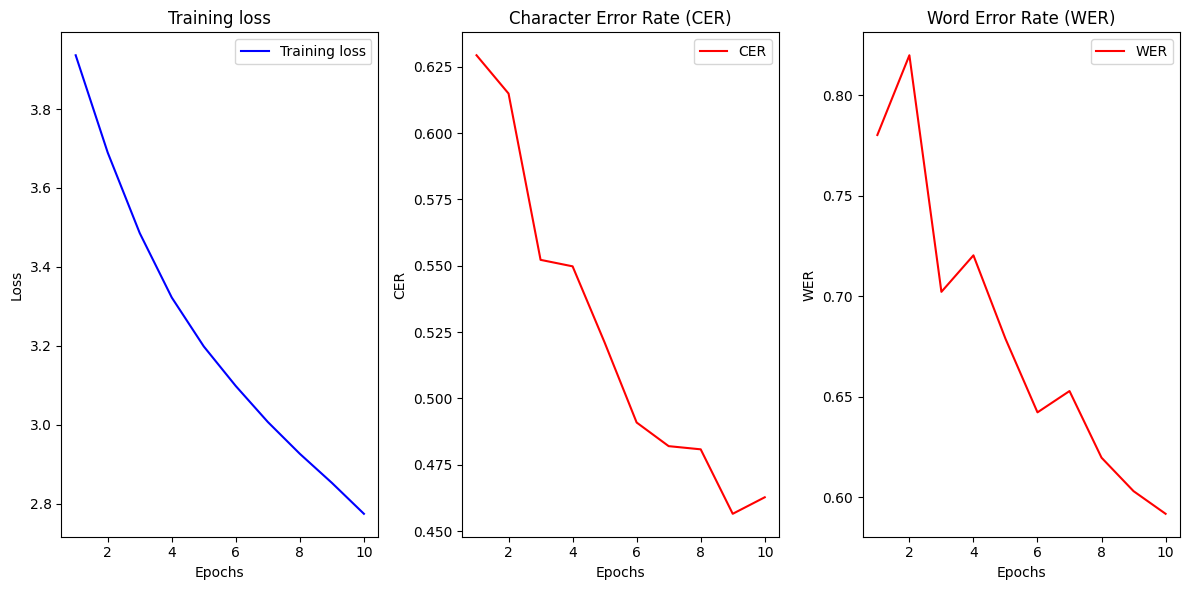

In [23]:
import matplotlib.pyplot as plt

# Assuming loss and CER contain values for each epoch
epochs = range(1, len(train_loss_list) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss_list, 'b', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, CER_list, 'r', label='CER')
plt.title('Character Error Rate (CER)')
plt.xlabel('Epochs')
plt.ylabel('CER')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, WER_list, 'r', label='WER')
plt.title('Word Error Rate (WER)')
plt.xlabel('Epochs')
plt.ylabel('WER')
plt.legend()

plt.tight_layout()
plt.show()

Label: اصحابنا ظ ع ك ، ث خ ض، ب س ش، ص غ ه اننا في الحج.  هل تعلم فائدة الكلمات التالية لهذا
Generated: أصحابنا ظ ع ك ، ث خ ض ، ب س ش ، ص غ أننا في الحج. هل تعلم فائدة الكلمات التالية لهذا


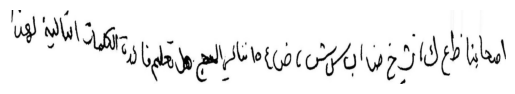

Label: وفي كتير من الاحيان بشكل مباشر في # إندلاع حرائق الغابات كما هد حاصل في غابات
Generated: وإن للحج. بدأت قوافل الحجيج حاج إثر آخر يلبي عند وصولنا طفنا وسعينا مع شيخ. كان


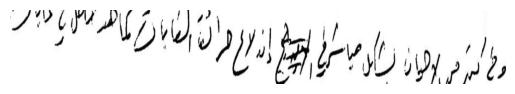

Label: الكلمات لهذا النص : مشمش ، دراق ، غيظ ، ناء ، بث ، نسر .
Generated: التالية لهذا النص : مشمش ، دراق ، غيظ ، ناء ، بث ، نسر.


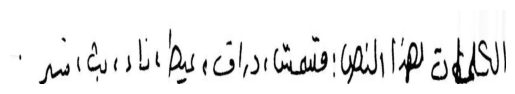

Label: العرب الآخرين، فيكاد يكون صفراً، فلا نجد في رواياته شيئا يعد تاريخا
Generated: التعليم ، و كان جاري في الخيمة يتكلم وهو نائم بكلمات لا أفهمها مثل انقض


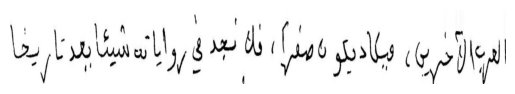

Label: والتقويم للحياة المعاصرة. # وتهتم أيضاً بدراسة  أصول
Generated: وإذا كان جاري في الخيمة يتكلم وهو نائم بكلمات لا أفهمها مثل انقض


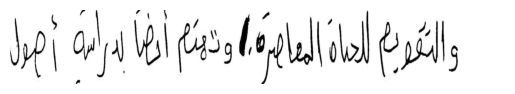

Label: ورد جوابا عن أسئلة الصحابة عن أعمال منافية للإسلام ارتكبوها في الجاهلية،
Generated: وهذا كان جاري في الخيمة يتكلم وهو نائم بكلمات لا أفهمها مثل انقض له الضابط لزمتك.


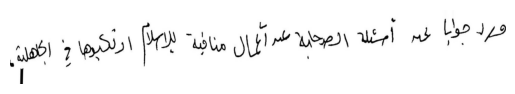

Label: خازن عفيف للحج . بدأت قوافل الحجيج حاج إثر آخر يلبي .
Generated: خازن عفيف للحج. بدأت قوافل الحجيج حاج إثر آخر يلبي.


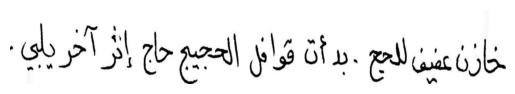

Label: ذهب نوح مظفر ضرغام بصحبة رؤوف بن لؤي رايق ظافر عطعوط وهلال
Generated: ذهب نوح مظفر ضرغام بصحبة رؤوف بن لؤي رايق ظافر عطعوط وهلال خازن


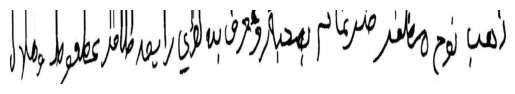

Label: الأطفال يكتسبون من خلاله المفاهيم الثقافية الأساسية، والمهارات المتعلقة بالتعبير .
Generated: الكلمات التالية لهذا النص : مشمش ، دراق ، غيظ ، ناء ، بث ، نسر.


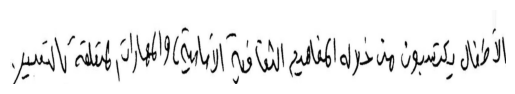

Label: في معظم الأحوال إلا حجرة واحدة فى كل طايق من أطباقة الثلاثه ،
Generated: في الخيمة يتكلم وهو نائم بكلمات لا أفهمها مثل انقض له


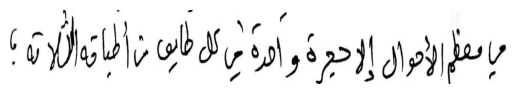

Label: مناخيه وبيئيه جوهريه في الكره الأرضيه خلال العقود الاربعه الماضيه سببها
Generated: مع شيخ. كان جاري في الخيمة يتكلم وهو نائم بكلمات لا أفهمها مثل انقض


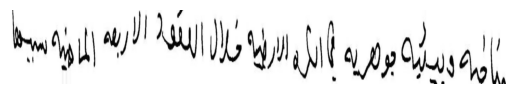

Label: الطاقة الحرارية : وتعتبر من الصور الاساسية للطاقة التي يمكن ان تتحول كل
Generated: الطبيعية للأشجارة للأرض. وكان الأشعة للطاقة للإدارة مئوية في


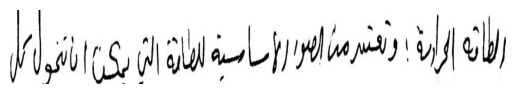

Label: في الخيمه يتكلم وهو نائم  بكلمات لا افهمها مثل انقض بغـلس له الضابط لزمتك. سالت.
Generated: بكلمات لا أفهمها مثل انقض له الضابط لزمتك. سألت راجح هل بلغ أصحابنا


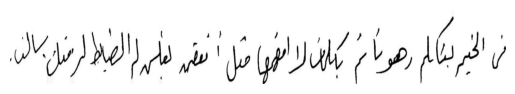

Label: كان جارى في الخيمة يتكلم وهو نائم  بكلمات لا أفهمها مثل انقض بغـلس له الضابط
Generated: كان جاري في الخيمة يتكلم وهو نائم بكلمات لا أفهمها مثل انقض له


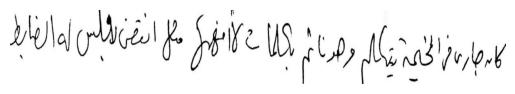

Label: تعد النقوش  والكتابات  في  طليعة المصادر التي تكوّن التاريخ الجاهلي ،
Generated: مثل انقض له الضابط لزمتك. سألت راجح هل بلغ أصحابنا ظ ع ك ، ث خ ض


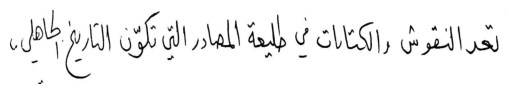

Label: (ولولا تزال المغضلة لوى جمهور قراء جائزة البووكر).وبدأت جوائز الكتاب وأهمها أورانج ، # و يتبريد
Generated: وإن " الهمداني " ، وكان " ، وبعد " ، و " ، ونحن " عرب " ، وهي " ، " ، وقد " ، وتغم " ، ولكن " ش ، و " ،


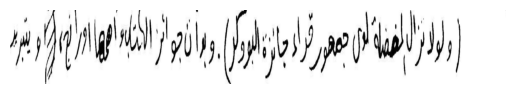

Label: من الحجارة الرملية الايولينية الحمراء، وعلى مسافة "35"
Generated: من الأشعة الشمسية. وكان الحرارة في التعليم.. وكانتة


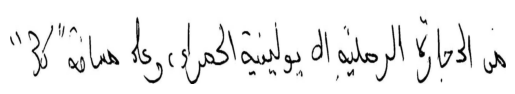

Label: و الإشجار باعتبارها تلعب دوراً إقتصادياً و بيئياً مهماً في الحياة . إن التغير الكبير
Generated: وهذا كان جاري في الخيمة يتكلم وهو نائم بكلمات لا أفهمها مثل انقض له


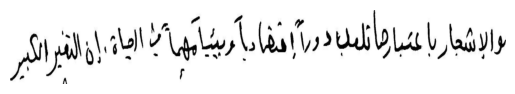

Label: في الخيمة يتكلم وهو نائم  بكلمات لا # أفهمها مثل انقض # بغـلس له
Generated: في الخيمة يتكلم وهو نائم بكلمات لا أفهمها مثل انقض له الضابط لزمتك.


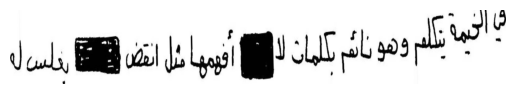

Label: ذهب نوح مظفر ضرغام  رؤوف بن لؤي رايق ظافر عطعوط وهلال خازن
Generated: ذهب نوح مظفر ضرغام بصحبة رؤوف بن لؤي رايق ظافر عطعوط وهلال خازن


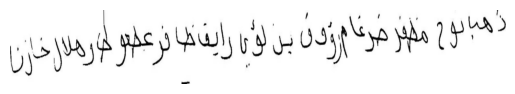

In [27]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import pandas as pd
import os


# Define the display function
def display_image_with_text(image_path, label, text, size=(300, 2000)):
    image = plt.imread(image_path)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size),
        transforms.ToTensor()
    ])
    image_tensor = transform(image)
    
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    plt.imshow(image_np)
    print("Label: "+label)
    print("Generated: "+text)
    plt.axis('off')
    plt.show()


# Generate predictions for the test set
for index, row in test_df.head(20).iterrows():
    # Load the image
    image_path = row['image_path']
    original_label = row['label']
    
    # Load the image as a tensor
    image = plt.imread(image_path)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((384,384)),
        transforms.ToTensor()
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Generate prediction
    outputs = model.generate(image_tensor)
    predicted_text = processor.tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

    # Display the image with original and predicted text
    display_image_with_text(image_path, original_label, predicted_text)
